In [26]:
from numpy.random import seed
seed(888)
from tensorflow import set_random_seed
set_random_seed(404)

import warnings
warnings.filterwarnings("ignore")

In [158]:
import os
import numpy as np
import tensorflow as tf
import keras

from keras.optimizers import Adam

from IPython.display import display
from keras.preprocessing.image import img_to_array,array_to_img

from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [63]:
LABELS = ['Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

LOG_DIR = 'tensorboard_logs/'

TOTAL_IP = 32*32*3
VALIDATION_SIZE = 10000
SMALL_SIZE = 1000

# Get Data

In [4]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
x_train[4].shape

(32, 32, 3)

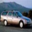

In [9]:
pic =  array_to_img(x_train[4])
display(pic)

In [11]:
y_train[4][0]

1

In [13]:
LABELS[y_train[4][0]]

'Car'

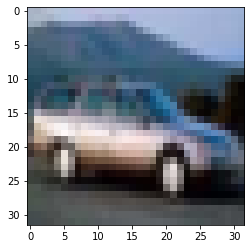

In [18]:
plt.imshow(array_to_img(x_train[4]))
plt.show()

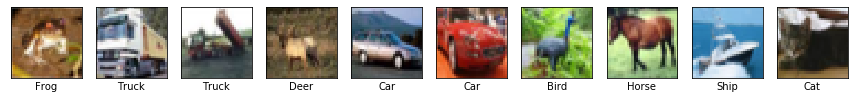

In [23]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(array_to_img(x_train[i]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(LABELS[y_train[i][0]])
    
    

In [27]:
x_train.shape

(50000, 32, 32, 3)

In [28]:
x_train[0].shape

(32, 32, 3)

In [29]:
nr_images,x,y,c = x_train.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| Channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| Channels = 3


In [31]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [37]:
type(x_train[0][0][0][0])

numpy.uint8

In [38]:
x_train[0][0][0][0]

59

In [39]:
x_train,x_test = x_train/255.0 , x_test/255.0

In [40]:
x_train[0][0][0][0]

0.23137254901960785

In [42]:
TOTAL_IP

3072

In [43]:
x_test.shape

(10000, 32, 32, 3)

In [44]:
x_train = x_train.reshape(x_train.shape[0],TOTAL_IP)

In [46]:
x_train.shape

(50000, 3072)

In [47]:
x_test = x_test.reshape(x_test.shape[0],TOTAL_IP)
x_test.shape

(10000, 3072)

## Create Validation Dataset

In [49]:
x_val = x_train[:VALIDATION_SIZE]
y_val = y_train[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [50]:
train_data = x_train[VALIDATION_SIZE:]
train_target = y_train[VALIDATION_SIZE:]
train_data.shape


(40000, 3072)

In [138]:
train_target.shape

(40000, 1)

### Creating Small dataset for processing (For illustration Purpose only)

In [52]:
x_train_xs = x_train[:SMALL_SIZE]
y_train_xs = y_train[:SMALL_SIZE]

# Defining the Neural Network using Keras

### Model 1 with no Regularisation

In [70]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_IP,activation='relu',name='m1_hidden1'),
    Dense(units=64, activation='relu',name='m1_hidden2'),
    Dense(units=16, activation='relu',name='m1_hidden3'),
    Dense(units=10, activation='softmax',name='m1_output')    
])
# adam = Adam()
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

### Model 2 with 1 Dropout Layer

In [77]:
model_2 = Sequential()
model_2.add(Dropout(rate=0.2,seed=42,input_shape=(TOTAL_IP,)))
model_2.add(Dense(units=128,activation='relu',name='m2_hidden_1'))
model_2.add(Dense(units=64,activation='relu',name='m2_hidden_2'))
model_2.add(Dense(units=15,activation='relu',name='m2_hidden_3'))
model_2.add(Dense(units=10,activation='softmax',name='output'))

# adam = Adam()
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

### Model 3 with 2 Dropout Layer

In [84]:
model_3 = Sequential()
model_3.add(Dropout(rate=0.2,seed=42,input_shape=(TOTAL_IP,)))
model_3.add(Dense(units=128,activation='relu',name='m3_hidden_1'))
model_3.add(Dropout(rate=0.25,seed=42))
model_3.add(Dense(units=64,activation='relu',name='m3_hidden_2'))
model_3.add(Dense(units=15,activation='relu',name='m3_hidden_3'))
model_3.add(Dense(units=10,activation='softmax',name='output'))

# adam = Adam()
model_3.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [71]:
type(model_1)

keras.engine.sequential.Sequential

In [72]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


## Tensorboard(Visualising Learning)

In [73]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_path = os.path.join(LOG_DIR,folder_name)
    try:
        os.makedirs(dir_path)
    except OSError as err:
        print('Error:',err)
    else:
        print('Successfully Created directory')
    
    return TensorBoard(log_dir=dir_path)

## Fit the model

In [74]:
samples_per_batch = 1000

In [75]:
# %%time
# nr_epochs = 50
# model_1.fit(x_train_xs,y_train_xs,batch_size=samples_per_batch,
#         callbacks=[get_tensorboard('Model 1')],epochs=nr_epochs,verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
Wall time: 1min 7s


In [78]:
# %%time
# nr_epochs = 50
# model_2.fit(x_train_xs,y_train_xs,batch_size=samples_per_batch,
#         callbacks=[get_tensorboard('Model 2')],epochs=nr_epochs,verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
Wall time: 1min 17s


In [81]:
%%time
nr_epochs = 100
model_1.fit(train_data,train_target,batch_size=samples_per_batch,
        callbacks=[get_tensorboard('Model 1 XL')],epochs=nr_epochs,verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
Wall time: 10min 28s


In [82]:
%%time
nr_epochs = 100
model_2.fit(train_data,train_target,batch_size=samples_per_batch,
        callbacks=[get_tensorboard('Model 2 XL')],epochs=nr_epochs,verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
Wall time: 18min 7s


In [85]:
%%time
nr_epochs = 100
model_3.fit(train_data,train_target,batch_size=samples_per_batch,
        callbacks=[get_tensorboard('Model 3 XL')],epochs=nr_epochs,verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
Wall time: 19min 21s


## Making Prediction from our model

In [86]:
x_val[0].shape

(3072,)

In [87]:
test = np.expand_dims(x_val[0],axis=0)
test.shape

(1, 3072)

In [88]:
np.set_printoptions(precision=3)

In [89]:
model_2.predict(test)

array([[0.086, 0.007, 0.09 , 0.189, 0.045, 0.148, 0.337, 0.091, 0.004,
        0.003]], dtype=float32)

In [90]:
model_2.predict(test).shape

(1, 10)

In [91]:
model_2.predict_classes(test)

array([6], dtype=int64)

In [92]:
y_val[0]

array([6], dtype=uint8)

## Making Prediction with all three models while all were giving around same accuracy.

In [94]:
for i in range(10):
    test_img = np.expand_dims(x_val[i],axis=0)
    predicted_val = model_2.predict_classes(test_img)
    print(f'Actual value:{y_val[i]} and predicted value:{predicted_val}')
    

Actual value:[6] and predicted value:[6]
Actual value:[9] and predicted value:[1]
Actual value:[9] and predicted value:[9]
Actual value:[4] and predicted value:[4]
Actual value:[1] and predicted value:[0]
Actual value:[1] and predicted value:[7]
Actual value:[2] and predicted value:[2]
Actual value:[7] and predicted value:[7]
Actual value:[8] and predicted value:[8]
Actual value:[3] and predicted value:[9]


In [95]:
for i in range(10):
    test_img = np.expand_dims(x_val[i],axis=0)
    predicted_val = model_1.predict_classes(test_img)
    print(f'Actual value:{y_val[i]} and predicted value:{predicted_val}')
    

Actual value:[6] and predicted value:[6]
Actual value:[9] and predicted value:[1]
Actual value:[9] and predicted value:[9]
Actual value:[4] and predicted value:[4]
Actual value:[1] and predicted value:[8]
Actual value:[1] and predicted value:[9]
Actual value:[2] and predicted value:[2]
Actual value:[7] and predicted value:[7]
Actual value:[8] and predicted value:[8]
Actual value:[3] and predicted value:[9]


In [96]:
for i in range(10):
    test_img = np.expand_dims(x_val[i],axis=0)
    predicted_val = model_3.predict_classes(test_img)
    print(f'Actual value:{y_val[i]} and predicted value:{predicted_val}')
    

Actual value:[6] and predicted value:[6]
Actual value:[9] and predicted value:[1]
Actual value:[9] and predicted value:[9]
Actual value:[4] and predicted value:[6]
Actual value:[1] and predicted value:[9]
Actual value:[1] and predicted value:[9]
Actual value:[2] and predicted value:[2]
Actual value:[7] and predicted value:[7]
Actual value:[8] and predicted value:[0]
Actual value:[3] and predicted value:[9]


# Evaluating the Model

In [97]:
model_2.metrics_names

['loss', 'acc']

In [98]:
x_test.shape

(10000, 3072)

## Evaluating our test data with all three model - And result is not much surprising

In [100]:
# Testing on model 1
test_loss_1,test_accuracy_1 = model_1.evaluate(x_test,y_test)
print(f'Test Loss is: {test_loss_1} and Test accuracy is:{test_accuracy_1}')

10000/10000 [==============================] - 2s 185us/step
Test Loss is: 1.459181413078308 and Test accuracy is:0.4875


In [101]:
# Testing on model 2
test_loss_2,test_accuracy_2 = model_2.evaluate(x_test,y_test)
print(f'Test Loss is: {test_loss_2} and Test accuracy is:{test_accuracy_2}')

10000/10000 [==============================] - 2s 205us/step
Test Loss is: 1.4252158529281616 and Test accuracy is:0.4882


In [103]:
# Testing on model 3
test_loss_3,test_accuracy_3 = model_3.evaluate(x_test,y_test)
print(f'Test Loss is: {test_loss_3} and Test accuracy is:{test_accuracy_3}')

10000/10000 [==============================] - 2s 214us/step
Test Loss is: 1.442236526298523 and Test accuracy is:0.4821


## Here-after continue with model 2 only

### Confusion Matrix

In [104]:
predictions = model_2.predict_classes(x_test)
conf_mat = confusion_matrix(y_test,predictions)

In [105]:
conf_mat.shape

(10, 10)

### Accuracy Score Using NN

In [159]:
accuracy_score(y_test,predictions)

0.4882

# Defining the Convolutional Neural Network using Keras

### Lets import the relevant libraries here

In [108]:
from keras.layers import Conv2D,MaxPooling2D,Flatten

In [128]:
(x_train_cnn,y_train_cnn),(x_test_cnn,y_test_cnn) = cifar10.load_data()

In [113]:
x_train_cnn.shape

(50000, 32, 32, 3)

In [137]:
y_train_cnn.shape

(50000, 1)

In [114]:
x_train_cnn.shape[1:]

(32, 32, 3)

In [122]:
model_cnn = Sequential()

In [123]:
model_cnn.add(Conv2D(32,(3,3),padding='same',input_shape=x_train_cnn.shape[1:],activation='relu'))
model_cnn.add(Conv2D(32,(3,3),activation='relu'))
model_cnn.add(MaxPooling2D(2,2))

model_cnn.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(Conv2D(64,(3,3),activation='relu'))
model_cnn.add(MaxPooling2D(2,2))

model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dense(10,activation='softmax'))

model_cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



In [124]:
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)            

In [129]:
x_train_cnn = x_train_cnn / 255.0
x_test_cnn = x_test_cnn / 255.0

In [131]:
x_train_cnn.shape

(50000, 32, 32, 3)

In [140]:
y_train_cnn = keras.utils.to_categorical(y_train_cnn,10)
y_test_cnn = keras.utils.to_categorical(y_test_cnn,10)

In [142]:
x_val_cnn = x_train_cnn[:VALIDATION_SIZE]
y_val_cnn = y_train_cnn[:VALIDATION_SIZE]

In [143]:
x_val_cnn.shape
# x_val_cnn[4]

(10000, 32, 32, 3)

# Ignore the below Error

## Started with epochs as 50 but interuppted the kernal at 16th epoch as it was computationally very expensive. You can check the error it is "Keyboard Interrupt"

In [145]:
model_cnn.fit(x_train_cnn,y_train_cnn,batch_size=samples_per_batch,epochs=50,
              validation_data=(x_val_cnn,y_val_cnn),shuffle=True,callbacks=[get_tensorboard('Model_CNN')])

Successfully Created directory
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 306s 6ms/step - loss: 1.8973 - acc: 0.3187 - val_loss: 1.6033 - val_acc: 0.4282
Epoch 2/50
50000/50000 [==============================] - 306s 6ms/step - loss: 1.5145 - acc: 0.4577 - val_loss: 1.4212 - val_acc: 0.4914
Epoch 3/50
50000/50000 [==============================] - 302s 6ms/step - loss: 1.3490 - acc: 0.5192 - val_loss: 1.2569 - val_acc: 0.5587
Epoch 4/50
50000/50000 [==============================] - 300s 6ms/step - loss: 1.2490 - acc: 0.5579 - val_loss: 1.1939 - val_acc: 0.5828
Epoch 5/50
50000/50000 [==============================] - 304s 6ms/step - loss: 1.1711 - acc: 0.5900 - val_loss: 1.0939 - val_acc: 0.6093
Epoch 6/50
50000/50000 [==============================] - 317s 6ms/step - loss: 1.0958 - acc: 0.6175 - val_loss: 1.0363 - val_acc: 0.6357
Epoch 7/50
50000/50000 [==============================] - 385s 8ms/step - loss: 1.0322 - ac

KeyboardInterrupt: 

In [146]:
model_cnn.metrics

['accuracy']

In [ ]:
for i in range(10):
    test_img = np.expand_dims(x_val[i],axis=0)
    predicted_val = model_3.predict_classes(test_img)
    print(f'Actual value:{y_val[i]} and predicted value:{predicted_val}')

In [147]:
x_test_cnn.shape

(10000, 32, 32, 3)

In [157]:
pred_cnn = model_cnn.predict_classes(x_test_cnn)

In [156]:
y_test_val[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=int64)

In [153]:
y_test_val = np.argmax(y_test_cnn,axis=1)

In [154]:
y_test_val[:2]

array([3, 8], dtype=int64)

### Accuracy Score Using CNN

In [160]:
accuracy_score(y_test_val,pred_cnn)

0.6968